# Representing Data within Scikit-Learn

The premise of ML is building models from data. Data within Scikit-Learn is best understood as tables of data.

### Tabular Data
A simple table is a 2D grid of data, where rows represent individual elements of the dataset. Let's load the infamous Iris dataset.

In [5]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Features Matrix

This layout demonstrates the two dimensional numerical array, commonly known as the "features matrix." By convention, this is denoted as X, with shape [n_samples, n_features] ( == [n_rows, n_columns] ).

### Target array

Alongside X, we work with a target array, denoted as "y". This is generally a 1D array of length n_samples, as an np.array or a pd.Series. Note: scikit-learn estimators can also handle multiple target variables.

/Users/jabir/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


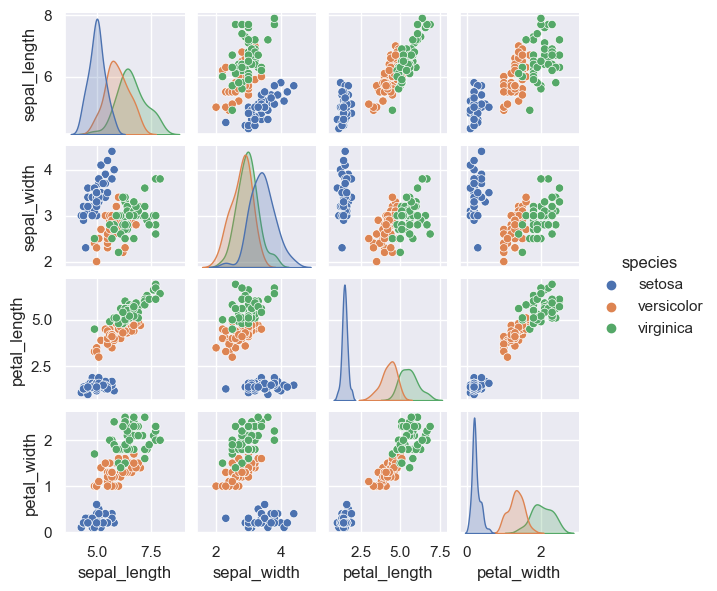

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.pairplot(iris, hue='species', size=1.5)

### The Estimator API

The general steps for using the API are as follows:
1. Choose a class of model by importing the apt. estimator class from the module
2. Choose model hyperparameters by instantiating class with desired values
3. Arrange data into features matrix and target vector
4. Fit model using the `.fit()` method for the model instance
5. Apply model to new data:
    - For supervised learning, we generally use `.predict()` for predicting labels for unknown data
    - For unsupervised learning, we infer or transform properties of the data using either `predict()` or `transform()`

### Supervised learning example: a simple linear regression

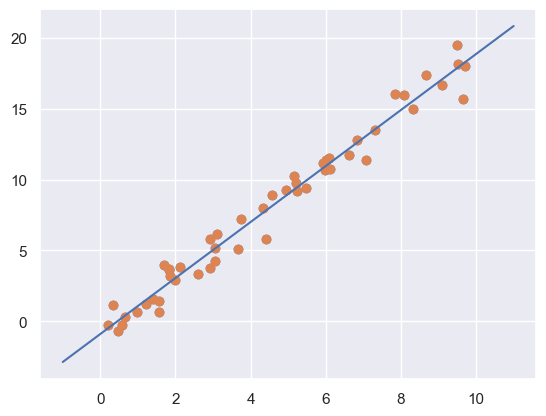

In [12]:
import numpy as np

randoms = np.random.RandomState(42)
x = 10 * randoms.rand(50)
y = 2*x - 1 + randoms.randn(50)
plt.scatter(x,y)

# choose model hyperparameters
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
X = x[:, np.newaxis]
model.fit(X,y)

"""
Once the model is trained, the primary task for supervised ML is to evaluate it based on
what is says about external data. Here, we use the predict() method.
"""

xfit = np.linspace(-1, 11)
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

plt.scatter(x, y)
plt.plot(xfit, yfit)

### Unsupervised learning example: iris dimensionality and clustering

The iris dataset imported at the start of the notebook is 4-dimensional. Dimensionality reduction asks whether there's a suitable lower-dimensional representation that retains the essential features of the data. A general use case of dimensionality reduction is as a visual aid for the data - it's a **lot** easier to plot data in 2D rather than 4D!

Principle Component Analysis is a common method for dimensionality reduction.

Using the general steps we stated above, we'll code the following:
1. Choose model class
2. Instantiate model with respective hyperparameters
3. Fit to data -- with unsupervised learning, y is omitted!
4. Transform data to two dimensions

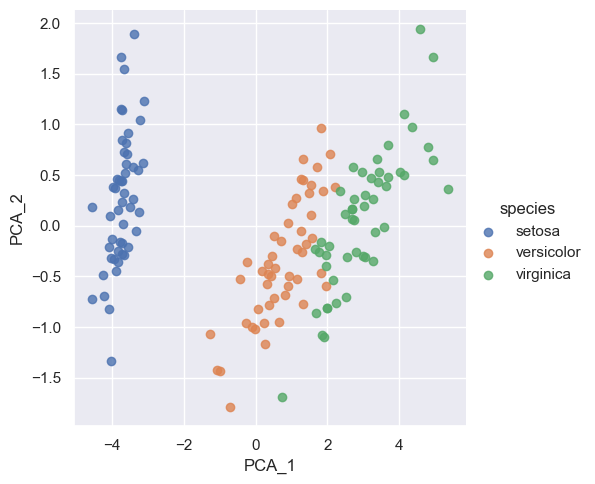

In [15]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
X_iris = iris.drop("species", axis=1)
model.fit(X_iris)
X_2D = model.transform(X_iris)

# plot results
iris["PCA_1"] = X_2D[:,0]
iris["PCA_2"] = X_2D[:,1]
sns.lmplot(data=iris, x="PCA_1", y="PCA_2", hue="species", fit_reg=False)

In the 2D representation, the species are pretty seperated, despite the PCA algo having no knowledge of the species labels. Pretty cool!

Onto the clustering - for this, we will be using a Gaussian mixture model (GMM), modelling the data as a collection of Gaussian blobs. GMMs are preferred to K means clustering, as we aren't bound to rigid hyperspheres. 

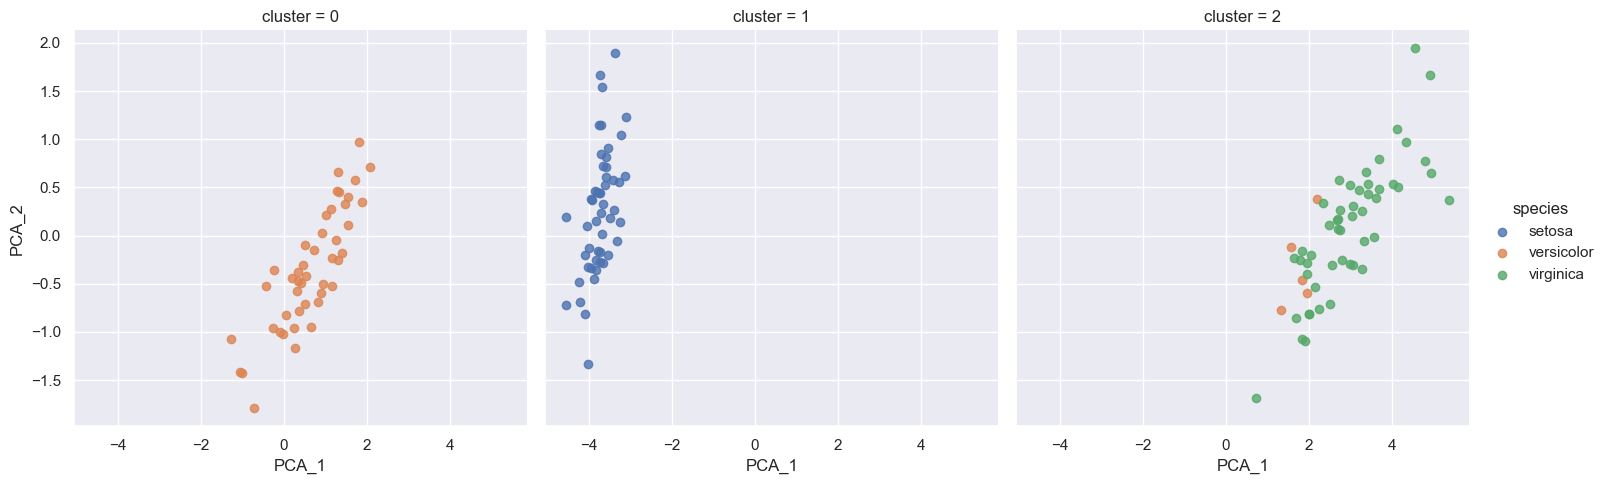

In [17]:
from sklearn.mixture import GaussianMixture as GMM
model = GMM(n_components=3, covariance_type='full')
model.fit(X_iris)
y_gmm = model.predict(X_iris)
iris["cluster"] = y_gmm
sns.lmplot(data=iris, x="PCA_1", y="PCA_2", hue="species", col="cluster", fit_reg=False)

### All this theory. Now what?

Let's apply it to the most common ML project of all time (after housing price predictions), the MNIST digits.

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a 3D array: 1797 samples, consisting of an 8x8 grid of pixels. In order to work with this data, we need a two dimensional, `[n_samples, n_features]` representation. If we treat each pixel in the image as a feature, by flattening out the pixel arrays as length-64 aarrays. We should also declare a target array, which gives the previously determined label for each digit.

/Users/jabir/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_isomap.py:352: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/jabir/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


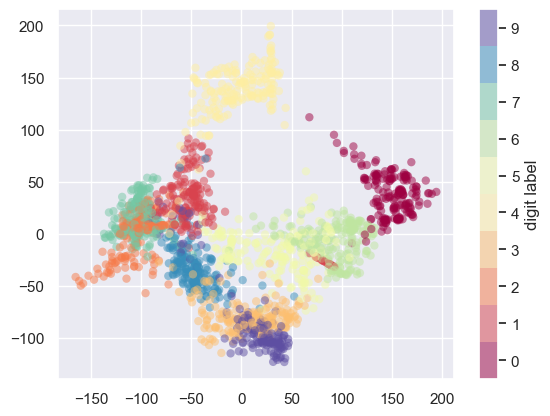

In [21]:
X = digits.data
y = digits.target

from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
projected = iso.transform(digits.data)
plt.scatter(projected[:, 0], projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

Now to classify the digits. We'll split the training and testing data, then fit a Gaussian Naive Bayes model.

In [23]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

# calculate the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

83.3% accurate. Not bad, but now we have no idea where the inaccuracies lie. If we use a **confusion matrix** we can see where the mislabeled points tend to be.

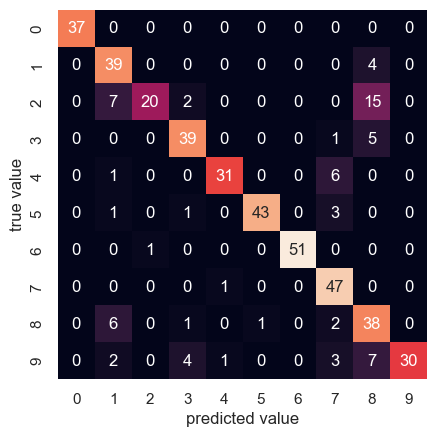

In [24]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

Looking at the plot above, we can see quite a few twos have been mislabelled as eights, as well as other discrepancies! We could improve this with random forests or SVMs! But this was meant to be just an introductory scikit-learn notebook!